# <center>ДЗ по лекции 9: Автокодировщики

### 1. Обучить многослойный автокодировщик:   
а. отрисовать классы в латентном представлении автокодировщика с двумерным латентным слоем,   
б. сделать tSNE над 32-мерным латентным слоем.   

### 2. Обучить автокодировщик с шумом:   
а. Добавить ко входным данным нормальный шум,   
б. Сделать отражение части изображения,   
в. Визуализировать веса первого внутреннего слоя (кодирующего, get_weights, plot_mnist).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np

%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform)

## Создаем необходимые классы

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [5]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [18]:
def train(epoch, models, log=None, noise=False):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        if noise:
            data = add_noise(data)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
    if log is not None:
        for k in models:
            log[k].append(models[k]._loss)   
            
    line = 'Epoch: {} [{}]\n'.format(epoch, train_size)
    losses = '\t' + 'Train set: ' + \
             ' '.join(['{}: loss: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
    report = line + losses
    print(report)

In [19]:
def test(models, loader, log=None, noise=False):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            if noise:
                data = add_noise(data)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
    line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
    
    losses = ' '.join([line(k, test_loss[k]) for k in models])
    report = '\t' + 'Test set: ' + losses        
    print(report)

#### Тренируем автокодировщики с 2- и 32-мерным латентным слоем, включая, естественно, энкодер

In [20]:
models = {'2': Net(2), '32': Net(32)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [21]:
%%time
for epoch in np.arange(100) + 1:
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Epoch: 1 [60000]
	Train set: 2: loss: 1.039214 32: loss: 0.412734
	Test set: 2: loss: 1.0391 32: loss: 0.4144
Epoch: 2 [60000]
	Train set: 2: loss: 0.957129 32: loss: 0.294602
	Test set: 2: loss: 0.9583 32: loss: 0.2976
Epoch: 3 [60000]
	Train set: 2: loss: 0.866590 32: loss: 0.270619
	Test set: 2: loss: 0.8685 32: loss: 0.2742
Epoch: 4 [60000]
	Train set: 2: loss: 0.778228 32: loss: 0.259354
	Test set: 2: loss: 0.7807 32: loss: 0.2574
Epoch: 5 [60000]
	Train set: 2: loss: 0.702683 32: loss: 0.240903
	Test set: 2: loss: 0.7023 32: loss: 0.2398
Epoch: 6 [60000]
	Train set: 2: loss: 0.632054 32: loss: 0.221977
	Test set: 2: loss: 0.6359 32: loss: 0.2261
Epoch: 7 [60000]
	Train set: 2: loss: 0.577730 32: loss: 0.214566
	Test set: 2: loss: 0.5793 32: loss: 0.2145
Epoch: 8 [60000]
	Train set: 2: loss: 0.529509 32: loss: 0.204443
	Test set: 2: loss: 0.5307 32: loss: 0.2034
Epoch: 9 [60000]
	Train set: 2: loss: 0.485540 32: loss: 0.190883
	Test set: 2: loss: 0.4891 32: loss: 0.1926
Epoch: 10 

#### посмотрим на кривые обучения

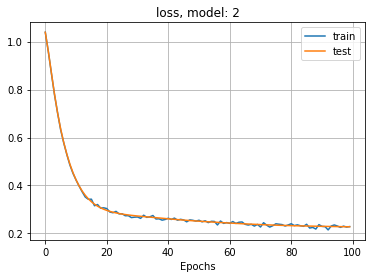

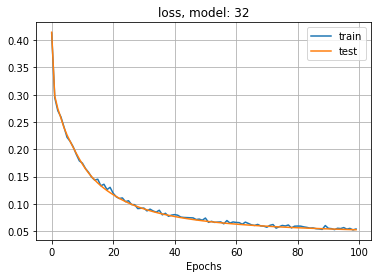

In [22]:
for model in models:
    plt.plot(train_log[model], label="train")
    plt.plot(test_log[model], label="test")
    plt.title(f"loss, model: {model}")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid()
    plt.show()

**Коммент:** модели, скорее всего, недообучены, но для наших целей достаточно

In [23]:
encoders ={model: models[model].E for model in models}

#### подготовим данные для визуализации

In [24]:
mnist_dataset = datasets.MNIST('./MNIST_data', train=True, download=True, transform=mnist_transform)

In [25]:
%%time
mnist_data = list(torch.utils.data.DataLoader(mnist_dataset, batch_size=len(mnist_dataset)))[0]
mnist_data[0].shape, mnist_data[1].shape

Wall time: 12.5 s


(torch.Size([60000, 1, 28, 28]), torch.Size([60000]))

In [26]:
def get_latent_out_labels(encoder, mnist_data, num_samples=200):
    data, targets = mnist_data
    x = data[:num_samples]
    labels = targets[:num_samples]
    with torch.no_grad():
        x = x.view(-1, 28*28)
        latent_outs = encoder(x)
    return latent_outs, labels

#### визуализируем 2-у мерные латентные представления

In [27]:
latent_outs, labels = get_latent_out_labels(encoders["2"], mnist_data, num_samples=10000)
latent_outs.shape, labels.shape

(torch.Size([10000, 2]), torch.Size([10000]))

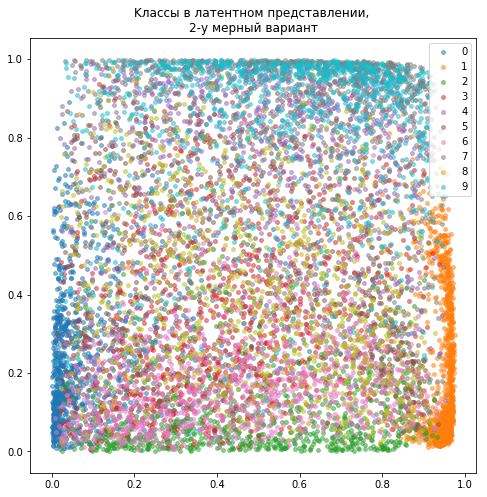

In [34]:
plt.figure(figsize=(8, 8))
for label in np.unique(labels):
    mask = (labels == label)
    plt.scatter(latent_outs[mask][:, 0], latent_outs[mask][:, 1], s=15, label=label, alpha=0.5)
    plt.title("Kлассы в латентном представлении, \n2-у мерный вариант")
    plt.legend()

#### визуализируем 32-у мерные латентные представления через TSNE преобразование

In [29]:
from sklearn.manifold import TSNE

In [30]:
latent_outs32, labels32 = get_latent_out_labels(encoders["32"], mnist_data, num_samples=10000)
latent_outs32.shape, labels32.shape

(torch.Size([10000, 32]), torch.Size([10000]))

In [31]:
%%time
latent_outs32_embedded = TSNE(n_components=2).fit_transform(latent_outs32)

Wall time: 1min 50s


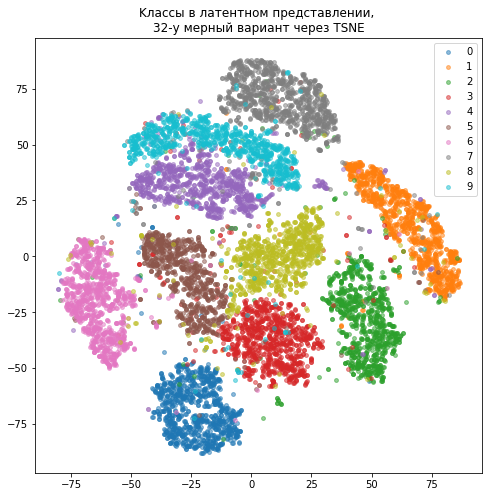

In [35]:
plt.figure(figsize=(8, 8))
for label in np.unique(labels32):
    mask = (labels32 == label)
    plt.scatter(latent_outs32_embedded[mask][:, 0], 
                latent_outs32_embedded[mask][:, 1], s=15, label=label, alpha=0.5)
    plt.title("Kлассы в латентном представлении, \n32-у мерный вариант через TSNE")
    plt.legend()

#### Коммент:
32-у мерный вариант латентного представления выглядит явно поинтереснее. Кроме того и лосс на кривых обучения заметно меньше, чем для 2-у мерного варианта

In [6]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [17]:
def add_noise(x, mode='crop', elementwise=False):
    if np.random.randint(2):
        return x
    x = x.clone()
    if elementwise:
        if mode == 'crop':
            for i in range(x.shape[0]):
                img_part = np.random.randint(5)
                zero_one = np.random.randint(2)*2 - 1  # -1 or 1
                if img_part == 0:
                    x[i, :, :14, :14] = zero_one  # вторая размерность - похоже, цвет (?)
                elif img_part == 1:
                    x[i, :, :14, 14:] = zero_one
                elif img_part == 2:
                    x[i, :, 14:, :14] = zero_one
                elif img_part == 3:
                    x[i, :, 14:, 14:] = zero_one
                elif img_part == 4:
                    x[i, :, 7:21, 7:21] = zero_one
        elif mode == 'mirror':
            pass
        elif mode == 'gaussian':
            pass    
    else:
        if mode == 'crop':
            img_part = np.random.randint(5)
            zero_one = np.random.randint(2)*2 - 1
            if img_part == 0:
                x[:, :, :14, :14] = zero_one
            elif img_part == 1:
                x[:, :, :14, 14:] = zero_one
            elif img_part == 2:
                x[:, :, 14:, :14] = zero_one
            elif img_part == 3:
                x[:, :, 14:, 14:] = zero_one
            elif img_part == 4:
                x[:, :, 7:21, 7:21] = zero_one
    return x


#### тестируем обучение

In [44]:
# for epoch in range(1, 21):
for epoch in range(1, 3):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [00000/60000] 16: 0.270630 32: 0.251899 64: 0.216521
Train Epoch: 1 [30000/60000] 16: 0.264952 32: 0.242280 64: 0.203433
Train Epoch: 1 [60000/60000] 16: 0.261351 32: 0.230407 64: 0.185376
Test set:
16: loss: 0.2647
32: loss: 0.2363
64: loss: 0.1939

Train Epoch: 2 [00000/60000] 16: 0.273534 32: 0.245468 64: 0.200539
Train Epoch: 2 [30000/60000] 16: 0.255383 32: 0.226441 64: 0.184402
Train Epoch: 2 [60000/60000] 16: 0.261780 32: 0.231490 64: 0.190043
Test set:
16: loss: 0.2613
32: loss: 0.2295
64: loss: 0.1866



In [10]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [00000/60000 (0%)] 16: 1.044241 32: 1.016514 64: 0.981115
Train Epoch: 1 [30000/60000 (50%)] 16: 0.871733 32: 0.662759 64: 0.415461
Train Epoch: 1 [60000/60000 (100%)] 16: 0.683663 32: 0.426546 64: 0.306121
Test set:
16: loss: 0.6697
32: loss: 0.4096
64: loss: 0.2953

Train Epoch: 2 [00000/60000 (0%)] 16: 0.671488 32: 0.415529 64: 0.304643
Train Epoch: 2 [30000/60000 (50%)] 16: 0.494269 32: 0.317786 64: 0.274582
Train Epoch: 2 [60000/60000 (100%)] 16: 0.392515 32: 0.293021 64: 0.269764
Test set:
16: loss: 0.3955
32: loss: 0.2944
64: loss: 0.2693

Train Epoch: 3 [00000/60000 (0%)] 16: 0.388266 32: 0.287929 64: 0.264279
Train Epoch: 3 [30000/60000 (50%)] 16: 0.342828 32: 0.285113 64: 0.268864
Train Epoch: 3 [60000/60000 (100%)] 16: 0.311963 32: 0.273006 64: 0.247174
Test set:
16: loss: 0.3167
32: loss: 0.2781
64: loss: 0.2550

Train Epoch: 4 [00000/60000 (0%)] 16: 0.313526 32: 0.275377 64: 0.251002
Train Epoch: 4 [30000/60000 (50%)] 16: 0.299895 32: 0.274049 64: 0.257251
T

In [13]:
data, _ = next(iter(test_loader))
noized = add_noise(data, elementwise=True)
output = models['64'](noized[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

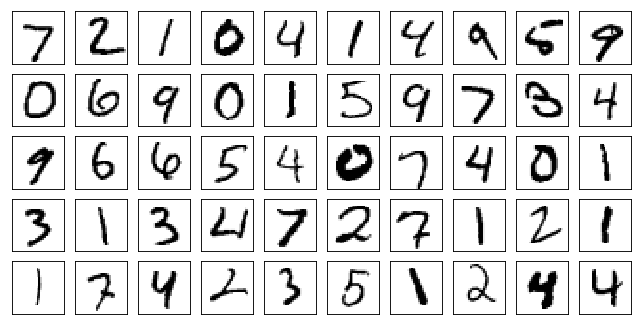

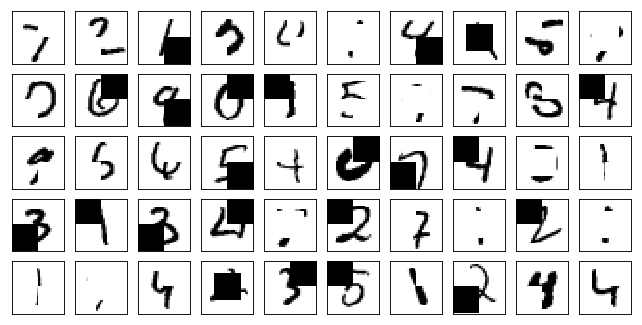

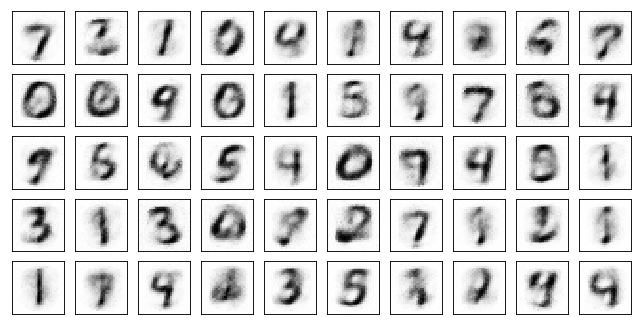

In [14]:
plot_mnist(data.data.numpy()[:50], (5, 10))
plot_mnist(noized[:50], (5, 10))
plot_mnist(to_plot, (5, 10))